In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163500 sha256=8b7ad355cc9bba9503453773cc8007dc45b3699563477e3c982a874c26997206
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
%matplotlib inline

from google.colab import drive
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD, accuracy
import surprise
import warnings; warnings.simplefilter('ignore')

In [ ]:
meta = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/archive/movies_metadata.csv')

meta.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
meta['genres']

0        [{'id': 16, 'name': 'Animation'}, {'id': 35, '...
1        [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...
2        [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...
3        [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
4                           [{'id': 35, 'name': 'Comedy'}]
                               ...                        
45461    [{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...
45462                        [{'id': 18, 'name': 'Drama'}]
45463    [{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...
45464                                                   []
45465                                                   []
Name: genres, Length: 45466, dtype: object

In [ ]:
print('////////////////////// Before ////////////////////// \n', meta['genres'].head(), '\n////////////////////// Before //////////////////////')

# dictionary안에 담겨있는 Genre 정보를 List 형태로 세팅
# 1. md['genres'].fillna('[]') : genres 컬럼에 null 값을 '[](빈 리스트 값)'으로 채워넣음
# 2. apply(literal_eval) : literal_eval를 사용하여 String으로 되어있는 값을 List & Dictionary로 사용할 수 있게 변환
# 3. apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else []) : x가 list인 경우 안에 들어있는 dictionary 중 name에 해당하는 값을 list에 담음
meta['genres'] = meta['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

print('////////////////////// After ////////////////////// \n', meta['genres'].head(), '\n////////////////////// After //////////////////////')

////////////////////// Before ////////////////////// 
 0    [{'id': 16, 'name': 'Animation'}, {'id': 35, '...
1    [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...
2    [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...
3    [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
4                       [{'id': 35, 'name': 'Comedy'}]
Name: genres, dtype: object 
////////////////////// Before //////////////////////
////////////////////// After ////////////////////// 
 0     [Animation, Comedy, Family]
1    [Adventure, Fantasy, Family]
2               [Romance, Comedy]
3        [Comedy, Drama, Romance]
4                        [Comedy]
Name: genres, dtype: object 
////////////////////// After //////////////////////


In [ ]:
print('vote ::: \n', meta[['vote_count', 'vote_average']].head())
vote_counts = meta[meta['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = meta[meta['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

vote ::: 
    vote_count  vote_average
0      5415.0           7.7
1      2413.0           6.9
2        92.0           6.5
3        34.0           6.1
4       173.0           5.7


5.244896612406511

In [ ]:
# 총 45460개의 영화 중 상위 5%는 2273번째
print(vote_counts.sort_values(ascending=False)[2273:2274])

# quantile는 데이터를 크기대로 정렬하였을 때 분위수를 구하는 함수. quantile(0.95)는 상위 5%에 해당하는 값을 찾는 것
m = vote_counts.quantile(0.95)
m

11561    434
Name: vote_count, dtype: int64


434.0

In [ ]:
print('release_date ::: \n', meta['release_date'].head())

# pd.to_datetime
# errors : {‘ignore’, ‘raise’, ‘coerce’}, default ‘raise’
# If ‘raise’, then invalid parsing will raise an exception
# If ‘coerce’, then invalid parsing will be set as NaT
# If ‘ignore’, then invalid parsing will return the input

# 'release_date'를 split해서 year만 추출
meta['year'] = pd.to_datetime(meta['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

print('year ::: \n', meta['year'].head())

release_date ::: 
 0    1995-10-30
1    1995-12-15
2    1995-12-22
3    1995-12-22
4    1995-02-10
Name: release_date, dtype: object
year ::: 
 0    1995
1    1995
2    1995
3    1995
4    1995
Name: year, dtype: object


In [ ]:
# 평가 수가 상위 5%인(434보다 큰) 데이터 추출
qualified = meta[(meta['vote_count'] >= m) & (meta['vote_count'].notnull()) & (meta['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

In [ ]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [ ]:
# Weighted Rating 상위 250개의 영화
qualified = qualified.sort_values('wr', ascending=False).head(250)

In [ ]:
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,"[Adventure, Fantasy, Action]",7.851924


In [ ]:
# stack() : stack이 (위에서 아래로 길게, 높게) 쌓는 것이면, unstack은 쌓은 것을 옆으로 늘어놓는것(왼쪽에서 오른쪽으로 넓게) 라고 연상이 될 것
# reset_index() : 기존의 행 인덱스를 제거하고 인덱스를 데이터 열로 추가
s = meta.apply(lambda x: pd.Series(x['genres']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
print(s.head(10))

gen_md = meta.drop('genres', axis=1).join(s)
print(gen_md.head(10))

0    Animation
0       Comedy
0       Family
1    Adventure
1      Fantasy
1       Family
2      Romance
2       Comedy
3       Comedy
3        Drama
Name: genre, dtype: object
   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
1  False                                                NaN  65000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
3  False                                                NaN  16000000   

                   

In [ ]:
def build_chart(genre, percentile=0.85):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)

    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title','year','vote_count','vote_average','popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')

    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)

    return qualified

In [ ]:
build_chart('Romance').head(15)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,8.565285
351,Forrest Gump,1994,8147,8,48.307194,7.971357
876,Vertigo,1958,1162,8,18.20822,7.811667
40251,Your Name.,2016,1030,8,34.461252,7.789489
883,Some Like It Hot,1959,835,8,11.845107,7.745154
1132,Cinema Paradiso,1988,834,8,14.177005,7.744878
19901,Paperman,2012,734,8,7.198633,7.713951
37863,Sing Street,2016,669,8,10.672862,7.689483
882,The Apartment,1960,498,8,11.994281,7.599317
38718,The Handmaiden,2016,453,8,16.727405,7.566166


In [ ]:
links_small = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/archive/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')
links_small.head()

0      862
1     8844
2    15602
3    31357
4    11862
Name: tmdbId, dtype: int64

In [ ]:
meta = meta.drop([19730, 29503, 35587])

In [ ]:
meta['id'] = meta['id'].astype('int')

In [ ]:
smd = meta[meta['id'].isin(links_small)]
smd.shape

(9099, 25)

In [ ]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

smd['description'].head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: description, dtype: object

In [ ]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

In [ ]:
print(tfidf_matrix[10])

  (0, 237880)	0.14118434571637967
  (0, 264587)	0.15239448296082492
  (0, 149397)	0.1346268358004416
  (0, 184592)	0.13757548758984955
  (0, 192607)	0.15239448296082492
  (0, 12515)	0.15239448296082492
  (0, 59410)	0.15239448296082492
  (0, 204261)	0.15239448296082492
  (0, 260369)	0.15239448296082492
  (0, 221301)	0.15239448296082492
  (0, 51585)	0.15239448296082492
  (0, 15732)	0.15239448296082492
  (0, 213978)	0.15239448296082492
  (0, 142130)	0.15239448296082492
  (0, 256956)	0.14583697304488685
  (0, 255009)	0.15239448296082492
  (0, 73255)	0.15239448296082492
  (0, 232769)	0.15239448296082492
  (0, 51809)	0.15239448296082492
  (0, 255952)	0.15239448296082492
  (0, 154810)	0.14583697304488685
  (0, 184597)	0.14583697304488685
  (0, 264425)	0.13213378623513553
  (0, 213982)	0.15239448296082492
  (0, 10509)	0.15239448296082492
  :	:
  (0, 259727)	0.15239448296082492
  (0, 237762)	0.08073572734141646
  (0, 192601)	0.13213378623513553
  (0, 12513)	0.13757548758984955
  (0, 59409)	0.14

In [ ]:
tfidf_matrix.shape

(9099, 268124)

In [ ]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
cosine_sim[0]

array([1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
       0.        ])

In [ ]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

print(titles.head(), indices.head())

0                      Toy Story
1                        Jumanji
2               Grumpier Old Men
3              Waiting to Exhale
4    Father of the Bride Part II
Name: title, dtype: object title
Toy Story                      0
Jumanji                        1
Grumpier Old Men               2
Waiting to Exhale              3
Father of the Bride Part II    4
dtype: int64


In [ ]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [ ]:
get_recommendations('The Godfather').head(10)

973      The Godfather: Part II
8387                 The Family
3509                       Made
4196         Johnny Dangerously
29               Shanghai Triad
5667                       Fury
2412             American Movie
1582    The Godfather: Part III
4221                    8 Women
2159              Summer of Sam
Name: title, dtype: object

In [ ]:
get_recommendations('Inception').head(10)

5239                              Cypher
141                                Crumb
6398                         Renaissance
653                            Lone Star
1703                               House
4739                    The Pink Panther
319                                 Cobb
2828    What Ever Happened to Baby Jane?
8867                     Pitch Perfect 2
979          Once Upon a Time in America
Name: title, dtype: object

In [ ]:
credits = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/archive/credits.csv')
keywords = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/archive/keywords.csv')

In [ ]:
credits['crew'][0]

'[{\'credit_id\': \'52fe4284c3a36847f8024f49\', \'department\': \'Directing\', \'gender\': 2, \'id\': 7879, \'job\': \'Director\', \'name\': \'John Lasseter\', \'profile_path\': \'/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f4f\', \'department\': \'Writing\', \'gender\': 2, \'id\': 12891, \'job\': \'Screenplay\', \'name\': \'Joss Whedon\', \'profile_path\': \'/dTiVsuaTVTeGmvkhcyJvKp2A5kr.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f55\', \'department\': \'Writing\', \'gender\': 2, \'id\': 7, \'job\': \'Screenplay\', \'name\': \'Andrew Stanton\', \'profile_path\': \'/pvQWsu0qc8JFQhMVJkTHuexUAa1.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f5b\', \'department\': \'Writing\', \'gender\': 2, \'id\': 12892, \'job\': \'Screenplay\', \'name\': \'Joel Cohen\', \'profile_path\': \'/dAubAiZcvKFbboWlj7oXOkZnTSu.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f61\', \'department\': \'Writing\', \'gender\': 0, \'id\': 12893, \'job\': \'Screenplay\', \'name\': \'A

In [ ]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
meta['id'] = meta['id'].astype('int')

In [ ]:
meta.shape

(45463, 25)

In [ ]:
meta = meta.merge(credits, on='id')
meta = meta.merge(keywords, on='id')

In [ ]:
smd = meta[meta['id'].isin(links_small)]
smd.shape

(9219, 28)

In [ ]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [ ]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
smd['director'] = smd['crew'].apply(get_director)

In [ ]:
# 출연진 중 주연배우 3명
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >= 3 else x)

In [ ]:
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [ ]:
# 출연진의 이름에서 공백 삭제
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [ ]:
# 감독의 이름에서 공백 삭제 및 3번 언급?
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x, x, x])

<Axes: >

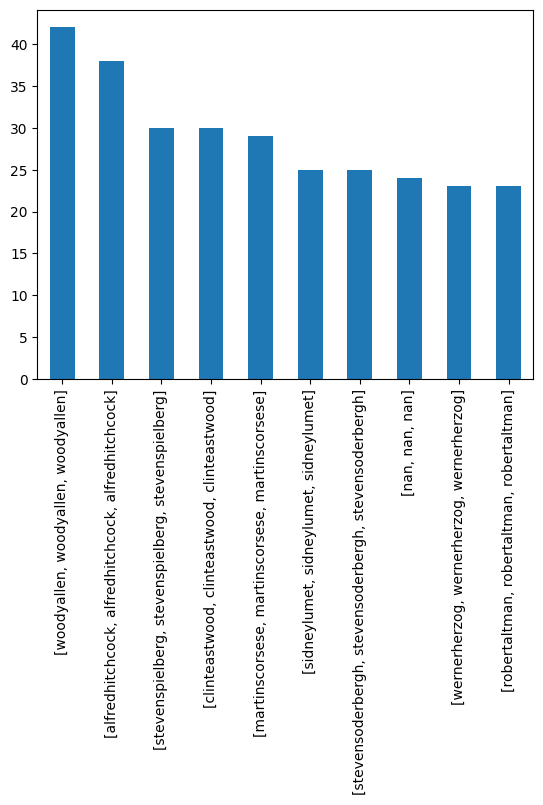

In [ ]:
smd.director.value_counts().head(10).plot(kind='bar')

<Axes: >

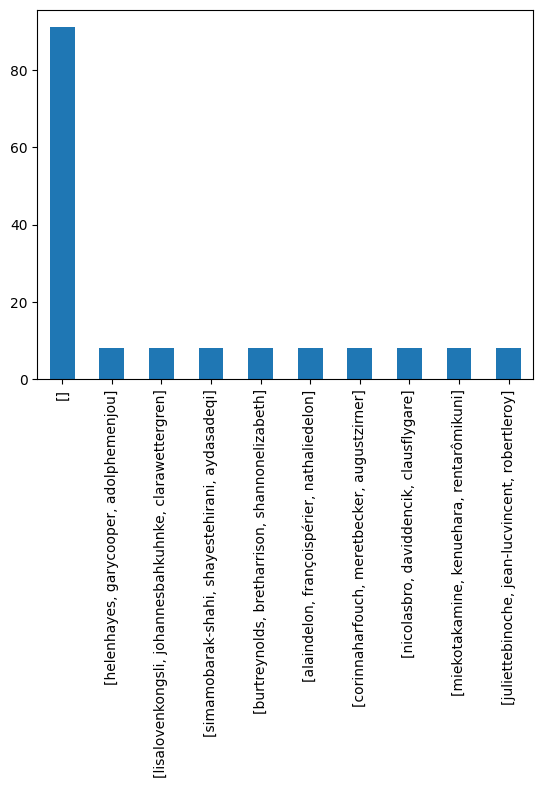

In [ ]:
smd.cast.value_counts().head(10).plot(kind='bar')

In [ ]:
s = smd.apply(lambda x: pd.Series(x['keywords']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [ ]:
s = s.value_counts()
s[:5]

independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
Name: keyword, dtype: int64

In [ ]:
# 2번 이상 등장한 키워드만 추출
s = s[s > 1]

In [ ]:
# 어근 추출을 통해 동일 의미&다른 형태의 단어(dogs&dog, imaging&image 등)를 동일한 단어로 인식
stemmer = SnowballStemmer('english')
print("dogs의 어근 : ", stemmer.stem('dogs'))
print("dog의 어근 : ", stemmer.stem('dog'))

dogs의 어근 :  dog
dog의 어근 :  dog


In [ ]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [ ]:
# 키워드의 어근을 찾아서 공백 제거 후 세팅
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [ ]:
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

In [ ]:
count = CountVectorizer(analyzer='word', ngram_range=(1,2), min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [ ]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [ ]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [ ]:
get_recommendations('The Dark Knight').head(10)

8031         The Dark Knight Rises
6218                 Batman Begins
6623                  The Prestige
2085                     Following
7648                     Inception
4145                      Insomnia
3381                       Memento
8613                  Interstellar
7659    Batman: Under the Red Hood
1134                Batman Returns
Name: title, dtype: object

In [ ]:
get_recommendations('Mean Girls').head(10)

3319               Head Over Heels
4763                 Freaky Friday
1329              The House of Yes
6277              Just Like Heaven
7905         Mr. Popper's Penguins
7332    Ghosts of Girlfriends Past
6959     The Spiderwick Chronicles
8883                      The DUFF
6698         It's a Boy Girl Thing
7377       I Love You, Beth Cooper
Name: title, dtype: object

In [ ]:
def improved_recommendations(title):
    print(title)
    idx = indices[title]
    print(idx)
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    print(movie_indices)

    movies = smd.iloc[movie_indices][['title','vote_count','vote_average','year']]
#     print(movies)

    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull())]
#     print(qualified)
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    print(qualified)
    return qualified

In [ ]:
improved_recommendations('The Dark Knight')

The Dark Knight
6981
[8031, 6218, 6623, 2085, 7648, 4145, 3381, 8613, 7659, 1134, 8927, 5943, 1260, 9024, 4021, 5809, 7362, 7561, 7582, 8001, 2754, 132, 2131, 2448, 5098]
                                   title  vote_count  vote_average  year  \
7648                           Inception       14075           8.1  2010   
8613                        Interstellar       11187           8.1  2014   
3381                             Memento        4168           8.1  2000   
6623                        The Prestige        4510           8.0  2006   
8031               The Dark Knight Rises        9263           7.6  2012   
6218                       Batman Begins        7511           7.5  2005   
1134                      Batman Returns        1706           6.6  1992   
9024  Batman v Superman: Dawn of Justice        7189           5.7  2016   
132                       Batman Forever        1529           5.2  1995   
1260                      Batman & Robin        1447           4.2  1

,title,vote_count,vote_average,year,wr
7648,Inception,14075,8.1,2010,8.014597
8613,Interstellar,11187,8.1,2014,7.993373
3381,Memento,4168,8.1,2000,7.830744
6623,The Prestige,4510,8.0,2006,7.758148
8031,The Dark Knight Rises,9263,7.6,2012,7.494595
6218,Batman Begins,7511,7.5,2005,7.376814
1134,Batman Returns,1706,6.6,1992,6.325180
9024,Batman v Superman: Dawn of Justice,7189,5.7,2016,5.674090
132,Batman Forever,1529,5.2,1995,5.209926
1260,Batman & Robin,1447,4.2,1997,4.441087


In [ ]:
# surprise 라이브러리의 Reader
reader = Reader()

In [ ]:
ratings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/archive/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
data = Dataset.load_from_df(ratings[['userId', 'movieId','rating']], reader)
# data.split(n_folds=5)

trainset = data.build_full_trainset()
testset = trainset.build_testset()

In [ ]:
svd = SVD()
# evaluate(svd, data, measures=['RMSE', 'MAE'])

svd.fit(trainset)
predictions = svd.test(testset)
accuracy.rmse(predictions)

RMSE: 0.6447


0.6446735464816575

In [ ]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [ ]:
svd.predict(1, 31, 3)

Prediction(uid=1, iid=31, r_ui=3, est=2.243758074462405, details={'was_impossible': False})

# 입출력에 따른 결과구현

In [ ]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [ ]:
id_map = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/archive/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')

In [ ]:
indices_map = id_map.set_index('id')

In [ ]:
def mmovie(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    movie_id = id_map.loc[title]['movieId']

    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]

    movies = smd.iloc[movie_indices][['title','vote_count','vote_average','id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [ ]:
mmovie(1, 'Avatar')

,title,vote_count,vote_average,id,est
522,Terminator 2: Judgment Day,4274.0,7.7,280,3.156375
1011,The Terminator,4208.0,7.4,218,3.097360
974,Aliens,3282.0,7.7,679,3.091020
2014,Fantastic Planet,140.0,7.6,16306,2.986778
8401,Star Trek Into Darkness,4479.0,7.4,54138,2.970290
8658,X-Men: Days of Future Past,6155.0,7.5,127585,2.817361
3060,Sinbad and the Eye of the Tiger,39.0,6.3,11940,2.815269
922,The Abyss,822.0,7.1,2756,2.787730
1668,Return from Witch Mountain,38.0,5.6,14822,2.722853
7265,Dragonball Evolution,475.0,2.9,14164,2.671767


In [ ]:
mmovie(50, 'Aliens')

,title,vote_count,vote_average,id,est
522,Terminator 2: Judgment Day,4274.0,7.7,280,3.902273
987,Alien,4564.0,7.9,348,3.841532
1011,The Terminator,4208.0,7.4,218,3.746251
7488,Avatar,12114.0,7.2,19995,3.472809
7498,Daybreakers,646.0,6.0,19901,3.456591
6967,Doomsday,374.0,5.8,13460,3.444453
344,True Lies,1138.0,6.8,36955,3.430022
3935,Impostor,136.0,6.1,4965,3.422214
7828,I Am Number Four,1606.0,5.9,46529,3.417431
6640,Déjà Vu,1519.0,6.6,7551,3.383715


In [ ]:
mmovie(500, 'Avatar')

,title,vote_count,vote_average,id,est
1011,The Terminator,4208.0,7.4,218,3.471883
1621,Darby O'Gill and the Little People,35.0,6.7,18887,3.336141
1376,Titanic,7770.0,7.5,597,3.301396
522,Terminator 2: Judgment Day,4274.0,7.7,280,3.250585
974,Aliens,3282.0,7.7,679,3.218234
8401,Star Trek Into Darkness,4479.0,7.4,54138,3.177204
2014,Fantastic Planet,140.0,7.6,16306,3.166463
3060,Sinbad and the Eye of the Tiger,39.0,6.3,11940,3.165257
2132,Superman II,642.0,6.5,8536,3.130563
922,The Abyss,822.0,7.1,2756,3.126544


In [ ]:
mmovie(1, 'Aliens')

,title,vote_count,vote_average,id,est
522,Terminator 2: Judgment Day,4274.0,7.7,280,3.482257
1011,The Terminator,4208.0,7.4,218,3.353853
987,Alien,4564.0,7.9,348,3.140448
922,The Abyss,822.0,7.1,2756,2.884254
1376,Titanic,7770.0,7.5,597,2.830259
6640,Déjà Vu,1519.0,6.6,7551,2.818437
7488,Avatar,12114.0,7.2,19995,2.742368
7498,Daybreakers,646.0,6.0,19901,2.712127
6905,I Am Legend,4977.0,6.9,6479,2.689872
3935,Impostor,136.0,6.1,4965,2.661664


In [ ]:
mmovie(100,'Jumanji')

,title,vote_count,vote_average,id,est
2020,October Sky,259.0,7.4,13466,3.973689
7345,Harry Potter and the Half-Blood Prince,5435.0,7.4,767,3.944208
7742,Harry Potter and the Deathly Hallows: Part 1,5708.0,7.5,12444,3.869741
7923,Captain America: The First Avenger,7174.0,6.6,1771,3.643378
7538,Percy Jackson & the Olympians: The Lightning T...,2079.0,6.0,32657,3.593774
5083,Peter Pan,671.0,6.9,10601,3.510706
6671,Arthur and the Invisibles,663.0,6.0,9992,3.495301
5158,Hidalgo,321.0,6.5,2023,3.480811
1668,Return from Witch Mountain,38.0,5.6,14822,3.473301
3981,Return to Never Land,304.0,6.1,16690,3.427847


In [ ]:
mmovie(100, 'Taxi Driver')

,title,vote_count,vote_average,id,est
8544,The Wolf of Wall Street,6768.0,7.9,106646,4.182327
6599,The Departed,4455.0,7.9,1422,4.111097
986,GoodFellas,3211.0,8.2,769,4.099838
1001,Raging Bull,968.0,7.7,1578,4.047991
7534,Shutter Island,6559.0,7.8,11324,3.868722
15,Casino,1343.0,7.8,524,3.851161
1104,Cape Fear,692.0,7.0,1598,3.848470
6047,The Aviator,1526.0,7.0,2567,3.769090
6309,No Direction Home: Bob Dylan,33.0,7.5,19082,3.738353
4439,Gangs of New York,1964.0,7.1,3131,3.726925
